# Task 2: Model Baseline and Data Preparation

## Setup

In [1696]:
import os
from pathlib import Path
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import missingno as msno
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score



## Import Data

In [1697]:
# import data 
df = pd.read_csv("../../data/raw/triathlon_watch_training_data_final.csv")


## Data Corrections

In [1698]:
# Make sure column names are lower case and eliminate spaces
df.columns = df.columns.str.lower()
# Replace spaces with underscores
df.columns = df.columns.str.replace(r" ", r"_", regex=True)

In [1699]:
#Elimiate column ID from the data set
df = df.drop(columns=['id'])

In [1700]:
#Transform the date column into numeric column
df["most_current_software_update"] = pd.to_datetime(df["most_current_software_update"], format="%Y-%m-%d")
df["most_current_software_update"] = df["most_current_software_update"].max() - df["most_current_software_update"]
df["most_current_software_update"] = df["most_current_software_update"].dt.days

In [1701]:
#Split column names in numerical and categorical features
numeric=df.select_dtypes(include=['float64']).columns.tolist() #list of numeric columns
categorical = df.select_dtypes(include=['object']).columns.to_list() #append all categorical columns to a list

## Step 0 - Minimal Preprocessing

In order to check the effect of each preprocessing step with a logistic regression model, minimal preprocessing steps like handling the missing values has to be done.

<Axes: >

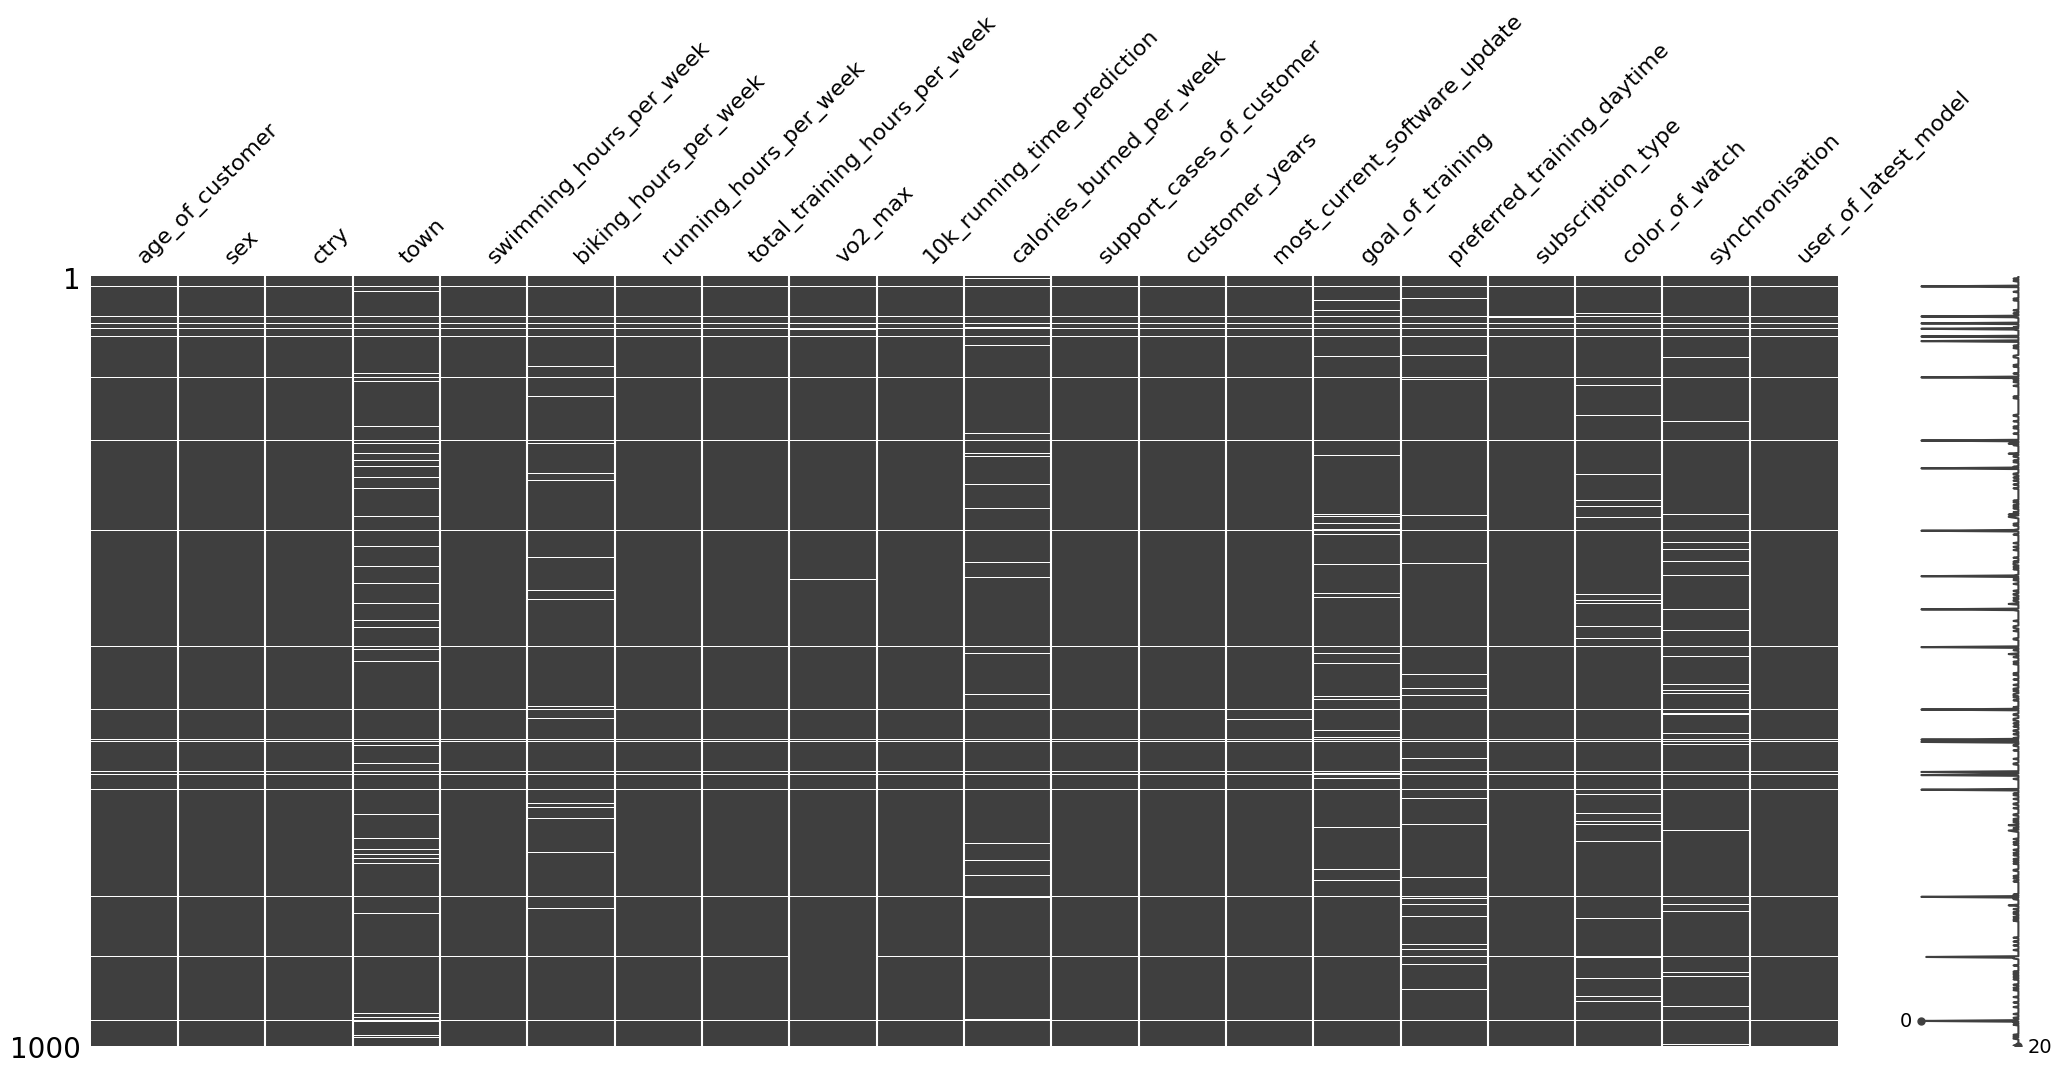

In [1702]:
df_step0 = df.copy()
msno.matrix(df_step0)

### Missing Value Handling - Listwise Deletion

Data rows with missing label, are useless for the machine learning algorithm and should be deleted

In [1703]:
#Listwise deletion all rows with missing values in the column 'user_of_latest_model'
df_step0=df_step0.drop(df_step0[df_step0['user_of_latest_model'].isnull()].index)

Next all rows, with more than two missing values are identified. These rows will also be removed from the dataset 

In [1704]:
#Listwise deletion (all rows with multiple missing values)
df_step0[df_step0.isnull().sum(axis=1)>2]

,age_of_customer,sex,ctry,town,swimming_hours_per_week,biking_hours_per_week,running_hours_per_week,total_training_hours_per_week,vo2_max,10k_running_time_prediction,calories_burned_per_week,support_cases_of_customer,customer_years,most_current_software_update,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch,synchronisation,user_of_latest_model


There are no rows left with more than two missing values. No further rows have to be removed

### Mean imputation of all missing values in numeric columns

For minimal preprocessing the imputation of missing values in numeric columns is made with the mean value.

In [1705]:
df_step0[numeric].isnull().sum() #number of missing values in each numeric column

age_of_customer                   0
swimming_hours_per_week           0
biking_hours_per_week            24
running_hours_per_week            0
total_training_hours_per_week     0
vo2_max                           4
10k_running_time_prediction       0
calories_burned_per_week         19
support_cases_of_customer         0
customer_years                    0
most_current_software_update      1
user_of_latest_model              0
dtype: int64

In [1706]:
#replace missing values in numeric columns with mean
for col in numeric:
    imputer = SimpleImputer(strategy='mean')
    df_step0[col] = imputer.fit_transform(df_step0[[col]])

df_step0[numeric].isnull().sum() #number of missing values in each numeric column

age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
most_current_software_update     0
user_of_latest_model             0
dtype: int64

### Modus imputation of all missing values in categorical columns

In [1707]:

#number of missing values in each categorical column
df_step0[categorical].isnull().sum() 

sex                            0
ctry                           0
town                          39
goal_of_training              28
preferred_training_daytime    24
subscription_type              1
color_of_watch                32
synchronisation               28
dtype: int64

In [1708]:
#replace missing values in categorical columns with modus
for col in categorical:
   # Calculate the mode of the column
    mode_value = df_step0[col].mode()[0]  # mode() returns a Series, [0] extracts the value
    # Replace missing values with the mode
    df_step0[col] = df_step0[col].fillna(mode_value)

df_step0[categorical].isnull().sum() #number of missing values in each numeric column

sex                           0
ctry                          0
town                          0
goal_of_training              0
preferred_training_daytime    0
subscription_type             0
color_of_watch                0
synchronisation               0
dtype: int64

In [1709]:
# Initialize DataFrame to store results
df_check = pd.DataFrame(columns=['Dataset', 'Accuracy', 'F1-Score'])

def check_processing_step(df, step):
    global df_check  # Access the global variable df_check

    # Define features (X) and target variable (y)
    X = df.drop(columns=['user_of_latest_model'])  # Features
    y = df['user_of_latest_model']  # Target variable

    # OneHot-Encoding for categorical columns
    X = pd.get_dummies(X, columns=df.select_dtypes(include=['object']).columns.to_list(), drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', max_iter=500)
    model.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results in DataFrame
    new_row = pd.DataFrame({'Dataset': [step], 'Accuracy': [accuracy], 'F1-Score': [f1]})
    
    # Check whether df_check is empty
    if df_check.empty:
        df_check = new_row  # Directly assign if df_check is empty
    else:
        df_check = pd.concat([df_check, new_row], ignore_index=True)


In [1710]:
check_processing_step(df_step0, 'Minimal Preprocessing (baseline)')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581


## Step 1 - Correction of Data Quality Issues

In the exploratory data anylsis, we saw that there are some inconsisent data in the column 'ctry', which might effect the machine learning performance of our model. In the following this data quality issues will be corrected.

In [1711]:
df_step1 = df_step0.copy()

### Removing inconsistent data

In [1712]:
# Show distribution of categorical values of the attribute "ctry" before corrections
df_step1['ctry'].value_counts()

ctry
Australia      200
USA            199
UK             191
India          186
Germany        179
Germayn         19
UnknownLand      4
Name: count, dtype: int64

In [1713]:
#Replcacement of all values 'Germanyn' with 'Germany'
df_step1['ctry'] = df_step1['ctry'].replace('Germayn', 'Germany')
#Show the distribution of categorical values of the attribute "ctry" after corrections
df_step1['ctry'].value_counts()

ctry
Australia      200
USA            199
Germany        198
UK             191
India          186
UnknownLand      4
Name: count, dtype: int64

### Removing redundant data

In [1714]:
# Show duplicate rows
duplicates = df_step1[df_step1.duplicated()]
duplicates

,age_of_customer,sex,ctry,town,swimming_hours_per_week,biking_hours_per_week,running_hours_per_week,total_training_hours_per_week,vo2_max,10k_running_time_prediction,calories_burned_per_week,support_cases_of_customer,customer_years,most_current_software_update,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch,synchronisation,user_of_latest_model
642,29.0,Other,Australia,Melbourne,5.06,1.44,0.25,6.75,54.86,43.60,3233.52,0.0,3.0,40.0,Fitness,Evening,Basic,Black,Yes,0.0
714,55.0,Other,UK,Birmingham,0.40,5.89,2.07,8.37,40.73,51.15,4460.39,0.0,7.0,84.0,Recreation,Morning,Premium,White,No,0.0


In [1715]:
# Remove duplicate rows
df_step1 = df_step1.drop_duplicates()
# Show duplicate rows
duplicates = df_step1[df_step1.duplicated()]
duplicates

,age_of_customer,sex,ctry,town,swimming_hours_per_week,biking_hours_per_week,running_hours_per_week,total_training_hours_per_week,vo2_max,10k_running_time_prediction,calories_burned_per_week,support_cases_of_customer,customer_years,most_current_software_update,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch,synchronisation,user_of_latest_model


In [1716]:

check_processing_step(df_step1, 'Data Quality Corrections')
df_check


,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252


## Step 2 - Missing value handling


In the following preprocessing step the missing values in the origial dataset. Where handled by regression imputation for numerical values and KNN imputation for categorical values.

In [1717]:
df_step2 = df.copy()

<Axes: >

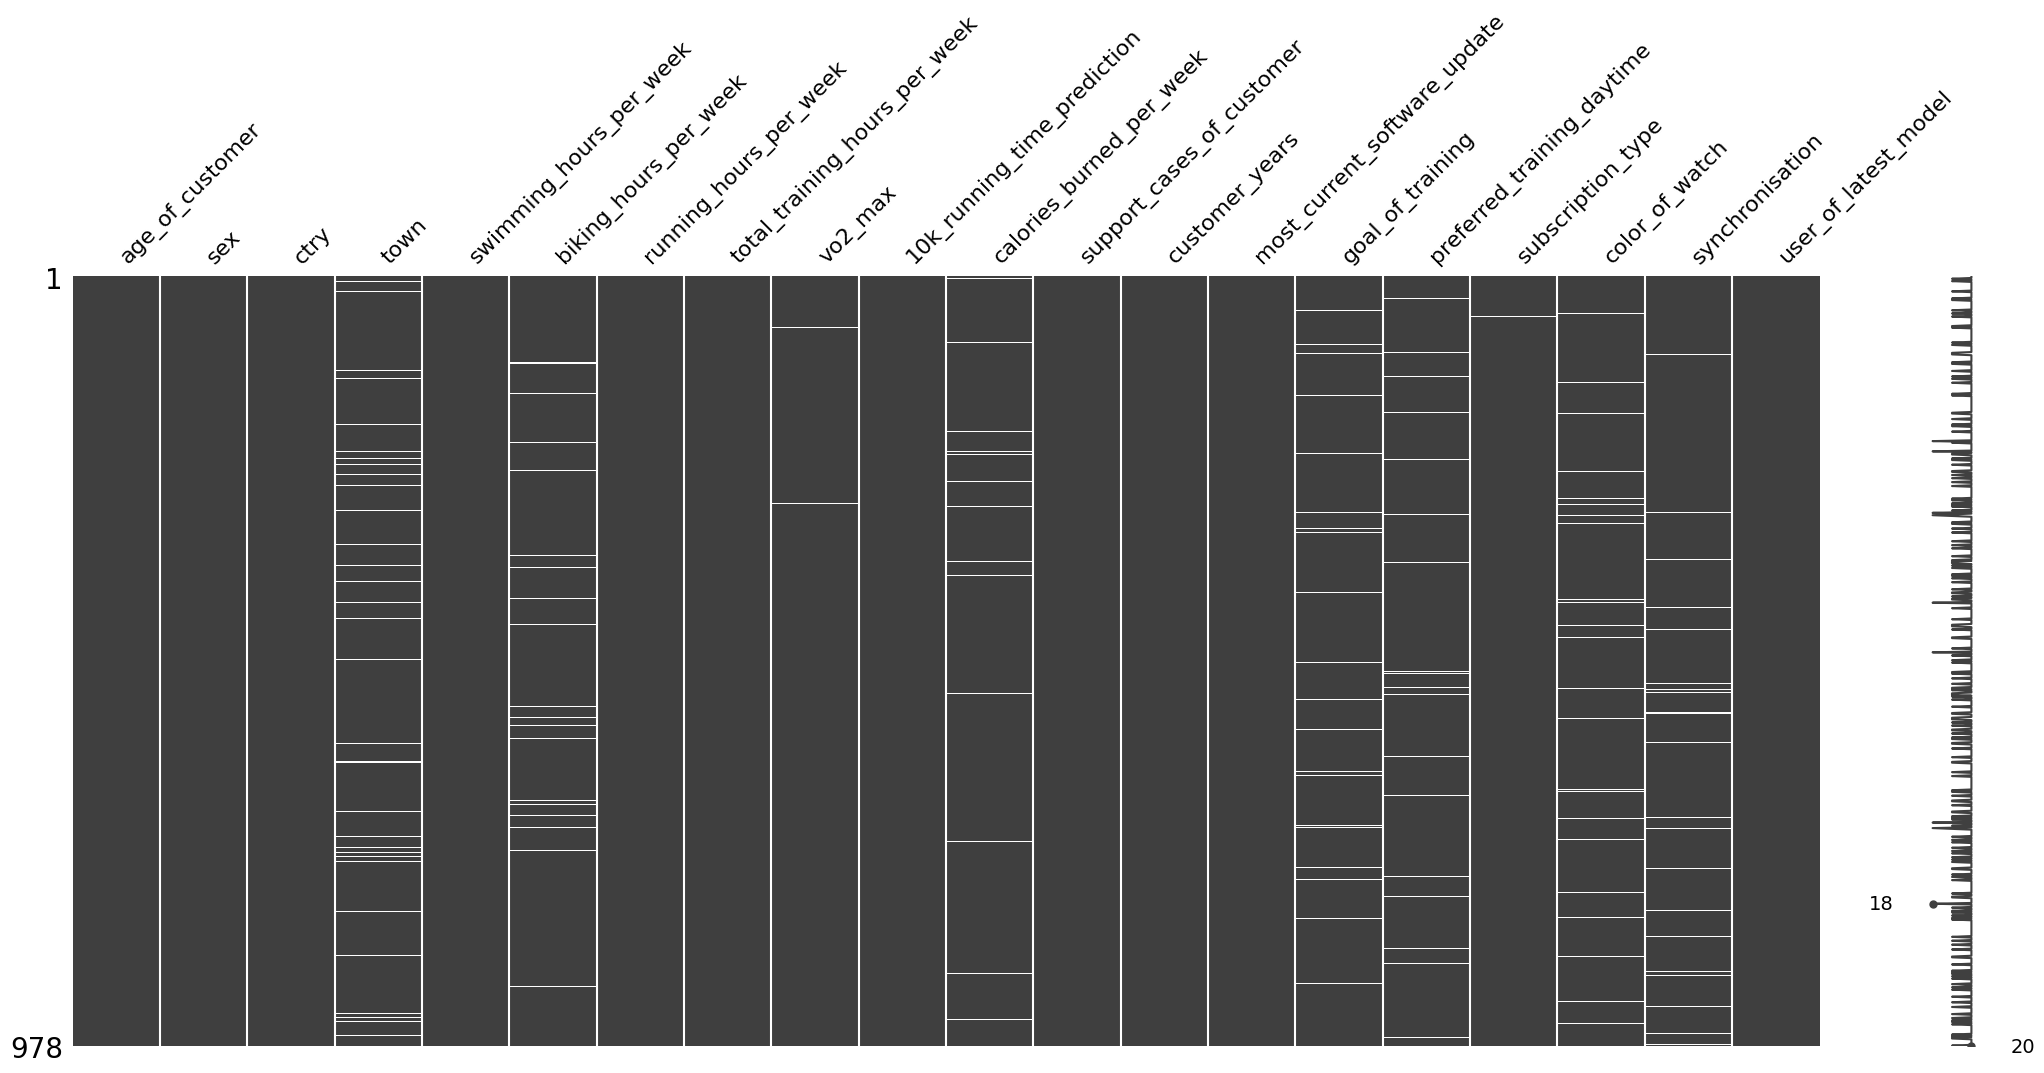

In [1718]:
#Listwise deletion all rows with missing values in the column 'user_of_latest_model'
df_step2=df_step2.drop(df_step2[df_step2['user_of_latest_model'].isnull()].index)
msno.matrix(df_step2)

### Regression imputation of numeric values

In [1719]:
df_step2[numeric].isnull().sum()

age_of_customer                   0
swimming_hours_per_week           0
biking_hours_per_week            24
running_hours_per_week            0
total_training_hours_per_week     0
vo2_max                           4
10k_running_time_prediction       0
calories_burned_per_week         19
support_cases_of_customer         0
customer_years                    0
most_current_software_update      1
user_of_latest_model              0
dtype: int64

In [1720]:
correlation_with_A = df_step2[numeric].corr()['biking_hours_per_week'].drop('biking_hours_per_week')  # Entferne die Korrelation mit sich selbst

# Ausgabe der Korrelation
print(correlation_with_A)

age_of_customer                  0.001405
swimming_hours_per_week          0.133546
running_hours_per_week           0.162726
total_training_hours_per_week    0.530162
vo2_max                          0.164993
10k_running_time_prediction     -0.159664
calories_burned_per_week         0.804664
support_cases_of_customer        0.030294
customer_years                   0.008436
most_current_software_update    -0.014664
user_of_latest_model             0.228377
Name: biking_hours_per_week, dtype: float64


In [1721]:
#  Iterative Imputation for numeric columns
imputer = IterativeImputer(max_iter=30, tol=1e-2, random_state=42, initial_strategy='median') #initial all missing values were replaced by median
df_step2_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_step2[numeric])) # creating a new dataframe with imputed values

df_step2_numeric_imputed.index = df_step2.index # adapt index of new dataframe to index of original dataframe
df_step2[numeric] = df_step2_numeric_imputed # replace numeric columns in original dataframe with imputed values

print(df_step2[numeric].isnull().sum()) # check if all missing values in numeric columns were imputed

age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
most_current_software_update     0
user_of_latest_model             0
dtype: int64


### KNN Imputation of categoric values

In [1722]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# 1. Kategorische Spalten in numerische Werte umwandeln
label_encoders = {}  # Dictionary, um die LabelEncoder zu speichern

for col in categorical:
    if df_step2[col].dtype == 'object':  # Überprüfen, ob es sich um eine kategorische Spalte handelt
        encoder = LabelEncoder()
        df_step2[col] = encoder.fit_transform(df_step2[col].fillna('Missing'))  # Umwandlung und fehlende Werte ersetzen
        label_encoders[col] = encoder  # Speichern des Encoders

# 2. KNN-Imputation auf den numerischen Werten anwenden
imputer = KNNImputer(n_neighbors=2)  # Anzahl der Nachbarn (k) einstellen
df_imputed_categorical = pd.DataFrame(imputer.fit_transform(df_step2[categorical]), columns=categorical)

# 3. Imputierte Werte zurück in kategorische Werte umwandeln
for col, encoder in label_encoders.items():
    df_imputed_categorical[col] = encoder.inverse_transform(df_imputed_categorical[col].round().astype(int))  # Rückumwandlung

# Ausgabe des imputierten DataFrames
df_imputed_categorical

df_imputed_categorical.index = df_step2.index # adapt index of new dataframe to index of original dataframe
df_step2[categorical] = df_imputed_categorical # replace numeric columns in original dataframe with imputed values

print(df_step2.isnull().sum()) # check if all missing values in numeric columns were imputed


age_of_customer                  0
sex                              0
ctry                             0
town                             0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
most_current_software_update     0
goal_of_training                 0
preferred_training_daytime       0
subscription_type                0
color_of_watch                   0
synchronisation                  0
user_of_latest_model             0
dtype: int64


In [1723]:
check_processing_step(df_step2, 'Missing values imputation')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273


## Step 3 - Outlier handling

Outliers in the numeric colums are identified and imputed by linear regression imputation. Therefore the outliers are first identified with IQR method and replaced by empty values. In the next step the empty values are replaced by the median as initial imputation. In a iterative imputation process the former missing values in every column are replaced by the value predicted by the linear regression model fitted by all other numeric columns. This process is repeated 30 times.

In [1724]:
df_step3 = df_step0.copy()

#  Detection of outliers with IQR-method
def detect_outliers_iqr(df):
    df_outliers = df.copy()
    for col in df.select_dtypes(include=np.number):  # Nur numerische Spalten
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[col] = df[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
    return df_outliers


#  Replacement of outliers mit NaN
data_numeric_no_outliers = detect_outliers_iqr(df_step3[numeric])

data_numeric_no_outliers.isnull().sum()


age_of_customer                   0
swimming_hours_per_week          13
biking_hours_per_week             7
running_hours_per_week           12
total_training_hours_per_week    13
vo2_max                          18
10k_running_time_prediction      12
calories_burned_per_week         12
support_cases_of_customer         0
customer_years                    0
most_current_software_update      0
user_of_latest_model              0
dtype: int64

In [1725]:
#  Iterative Imputation for numeric columns
imputer = IterativeImputer(max_iter=30, tol=1e-2, random_state=42, initial_strategy='median') #initial all missing values were replaced by median
data_numeric_imputed = pd.DataFrame(imputer.fit_transform(data_numeric_no_outliers)) # creating a new dataframe with imputed values

data_numeric_imputed.index = df_step3.index # adapt index of new dataframe to index of original dataframe
#df_imputed_numeric = df_step3.copy() # create a copy of the original dataframe
df_step3[numeric] = data_numeric_imputed # replace numeric columns in original dataframe with imputed values

print(df_step3[numeric].isnull().sum()) # check if all missing values in numeric columns were imputed

age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
most_current_software_update     0
user_of_latest_model             0
dtype: int64


In [1726]:
check_processing_step(df_step3, 'Outlier Imputation')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590


## Step 4 - Quantile Transformation

In [1727]:
df_step4 = df_step0.copy()

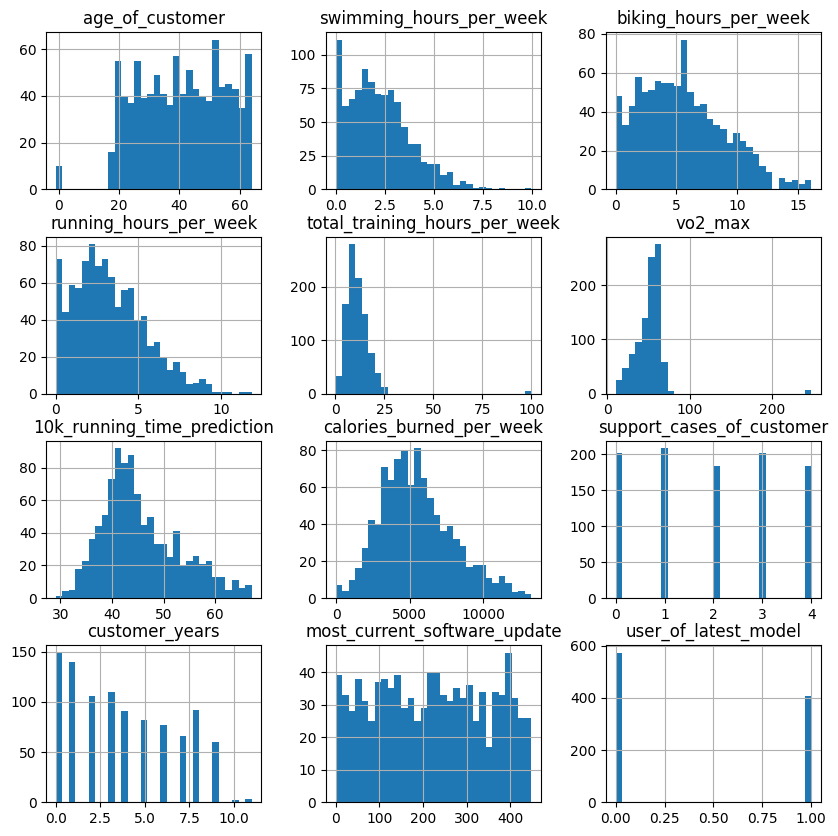

In [1728]:
# Showing the distribution of the numerical data with histograms
%matplotlib inline
hist = df_step4[numeric].hist(bins=30,figsize=(10, 10))

In [1729]:
numericwithoutlabel = numeric.copy()

# remove label from the numeric list
numericwithoutlabel.remove('user_of_latest_model')

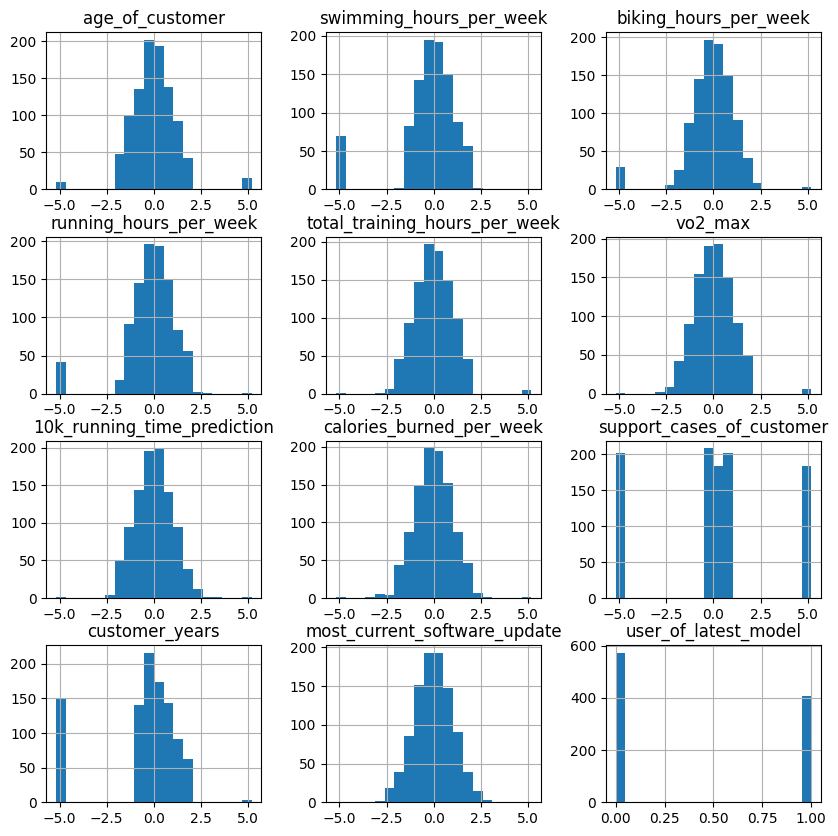

In [1730]:
from sklearn.preprocessing import QuantileTransformer

# Initialize QuantileTransformer to transform numerical features into a normal distribution
qt = QuantileTransformer(n_quantiles=25, output_distribution='normal', random_state=0)

# Apply the transformation to all numerical columns
trans_x = qt.fit_transform(df_step4[numericwithoutlabel])  

# Convert the transformed array back to a DataFrame and replace original numerical columns
df_step4[numericwithoutlabel] = pd.DataFrame(trans_x, columns=numericwithoutlabel, index=df_step4.index)

# Plot histograms for each numerical column to visualize the distribution
df_step4[numeric].hist(bins=20, figsize=(10, 10))
plt.show()


In [1731]:
check_processing_step(df_step4, 'Quantile Transformation')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590
4,Quantile Transformation,0.780612,0.718954


## Step 5 -  Power Transformation

In [1732]:
df_step5 = df_step0.copy()

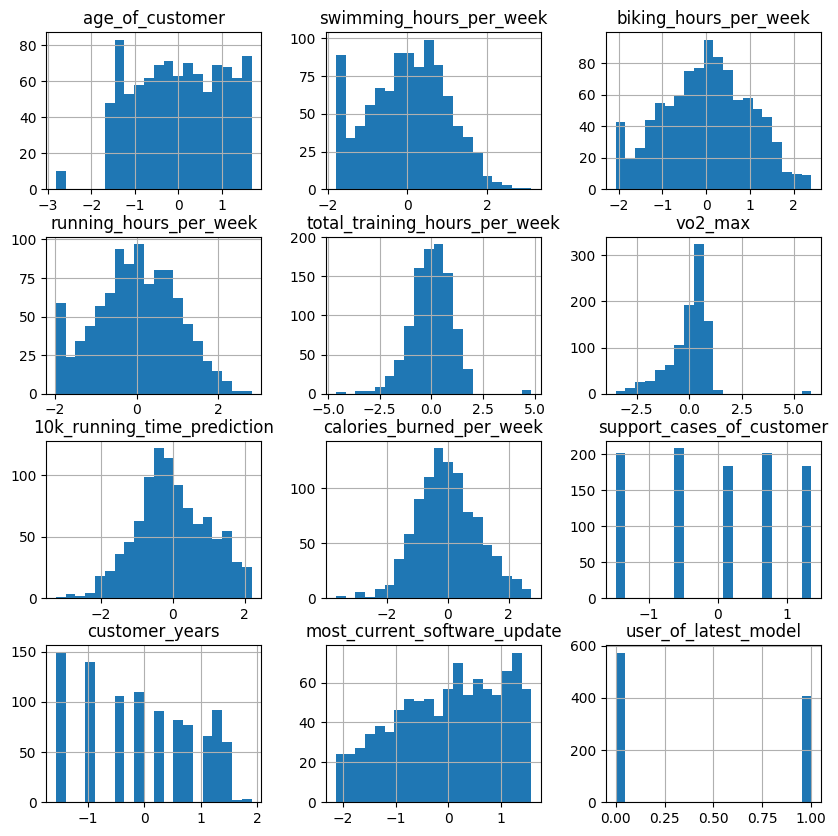

In [1733]:
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

# Initialize PowerTransformer (Yeo-Johnson is default, Box-Cox requires only positive data)
pt = PowerTransformer(method='yeo-johnson', standardize=True)  

# Apply the transformation to all numerical columns
trans_x = pt.fit_transform(df_step5[numericwithoutlabel])  

# Convert the transformed array back to a DataFrame and replace original numerical columns
df_step5[numericwithoutlabel] = pd.DataFrame(trans_x, columns=numericwithoutlabel, index=df_step5.index)

# Plot histograms for each numerical column to visualize the distribution
df_step5[numeric].hist(bins=20, figsize=(10, 10))
plt.show()

In [1734]:
check_processing_step(df_step5, 'Power Transformation')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590
4,Quantile Transformation,0.780612,0.718954
5,Power Transformation,0.795918,0.740260


## Step 5 - Min-Max scaling

In [1735]:
df_step6 = df_step0.copy()

In [1736]:
# Initialisiere den MinMaxScaler (Standardbereich ist [0,1])
scaler = MinMaxScaler()

# Wende die Normalisierung nur auf die numerischen Spalten an
df_step5[numeric] = scaler.fit_transform(df_step5[numeric])

check_processing_step(df_step6, 'Feature scaling - Normalization')
df_check



,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590
4,Quantile Transformation,0.780612,0.718954
5,Power Transformation,0.795918,0.740260
6,Feature scaling - Normalization,0.780612,0.722581


## Step 6 - Standardization scaling

In [1737]:
df_step7 = df_step0.copy()

In [1738]:
from sklearn.preprocessing import StandardScaler

# Initialisiere den StandardScaler
scaler = StandardScaler()

# Wende die Standardisierung nur auf die numerischen Spalten an
df_step7[numericwithoutlabel] = scaler.fit_transform(df_step7[numericwithoutlabel])

check_processing_step(df_step7, 'Feature scaling - Standardization')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590
4,Quantile Transformation,0.780612,0.718954
5,Power Transformation,0.795918,0.740260
6,Feature scaling - Normalization,0.780612,0.722581
7,Feature scaling - Standardization,0.785714,0.734177


## Step 8 - Ordinal encoding

In [1739]:
df_step8 = df_step0.copy()

In [1740]:

#show unique values categorical variables
for col in categorical:
    if df_step8[col].nunique() < 20:
        print(f'{col}: {df_step8[col].unique()}')

sex: ['Other' 'Male' 'Female']
ctry: ['UK' 'Australia' 'India' 'Germany' 'USA' 'Germayn' 'UnknownLand']
town: ['Birmingham' 'Sydney' 'Bangalore' 'Munich' 'Mumbai' 'Berlin' 'New York'
 'Chicago' 'Hamburg' 'London' 'Manchester' 'Brisbane' 'Melbourne' 'Delhi'
 'Los Angeles']
goal_of_training: ['Fitness' 'Competition' 'Recreation']
preferred_training_daytime: ['Evening' 'Afternoon' 'Morning']
subscription_type: ['Free' 'Premium' 'Basic']
color_of_watch: ['White' 'Black']
synchronisation: ['Yes' 'No']


subscription_type, preferred_training_daytime and goal_of_training are categorical ordinal columns and could be encoded by ordinal encoding

In [1741]:
from sklearn.preprocessing import OrdinalEncoder

# Initialisze the OrdinalEncoder with the categories 
encoder = OrdinalEncoder(categories=[['Recreation', 'Fitness', 'Competition']])  

# Aplly the transformation to the column 'goal_of_training'
df_step8['goal_of_training'] = encoder.fit_transform(df_step8[['goal_of_training']])


In [1742]:
# Initialisze the OrdinalEncoder with the categories 
encoder = OrdinalEncoder(categories=[['Morning', 'Afternoon', 'Evening']])  

# Aplly the transformation to the column 'preferred_training_daytime'
df_step8['preferred_training_daytime'] = encoder.fit_transform(df_step8[['preferred_training_daytime']])

In [1743]:
# Initialisze the OrdinalEncoder with the categories 
encoder = OrdinalEncoder(categories=[['Free', 'Basic', 'Premium']])  

# Aplly the transformation to the column 'subscription_type'
df_step8['subscription_type'] = encoder.fit_transform(df_step8[['subscription_type']])

In [1744]:
check_processing_step(df_step8, 'Ordinal encoding')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590
4,Quantile Transformation,0.780612,0.718954
5,Power Transformation,0.795918,0.740260
6,Feature scaling - Normalization,0.780612,0.722581
7,Feature scaling - Standardization,0.785714,0.734177
8,Ordinal encoding,0.785714,0.727273


## Step 9 - Feature Selection

In [1745]:
df_step9 = df_step0.copy()

### Feature selection for continuous features and nominal label using anova-f statistic

In [1746]:
continuous_features =['age_of_customer','swimming_hours_per_week','biking_hours_per_week','running_hours_per_week','total_training_hours_per_week','vo2_max','10k_running_time_prediction','calories_burned_per_week','most_current_software_update']
df_cintinuous_features = df_step9[continuous_features]
label = df_step9['user_of_latest_model']

In [1747]:
#create a new dataframe with p-values of anova test for each numeric feature with label
from scipy.stats import f_oneway
anova_p_values = pd.DataFrame(index=continuous_features, columns=['p-value'])
for i in continuous_features:
    data_anova = pd.concat([df_cintinuous_features[i], label], axis=1)
    groups = []
    for j in data_anova['user_of_latest_model'].unique():
        groups.append(data_anova[data_anova['user_of_latest_model']==j][i])
    stat, p = f_oneway(*groups)
    anova_p_values.loc[i,'p-value'] = p
anova_p_values

,p-value
age_of_customer,0.0
swimming_hours_per_week,0.0
biking_hours_per_week,0.0
running_hours_per_week,0.0
total_training_hours_per_week,0.0
vo2_max,0.0
10k_running_time_prediction,0.0
calories_burned_per_week,0.0
most_current_software_update,0.799767


Anova test shows that the variable most_current_software_update has no significant effect on the target variable. 

<Axes: >

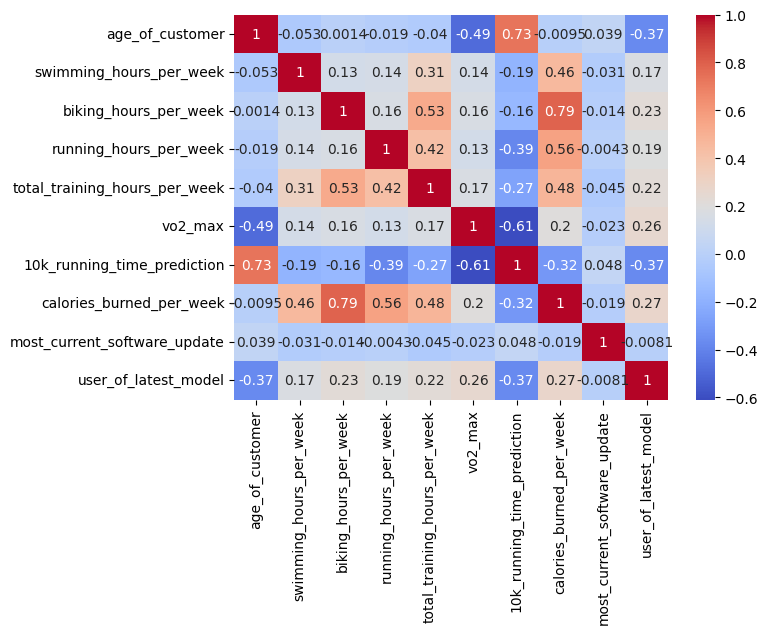

In [1748]:
#calculate correlation between continuous features and label
continuous_features_label = continuous_features + ['user_of_latest_model']
# Create a new dataframe with only continuous features and label
df_continuous_features_label = df_step9[continuous_features_label]
# Calculate the correlation matrix
correlation = df_continuous_features_label.corr()
#visualize correlation in a heatmap, low correlation is blue, high correlation is red
plt.figure(figsize=(7,5))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Correlation matrix confirms the results of anova test. Lowest correlation coefficient was calculated between target variable (user_of_latest_model) and most_current_software_update. most_current_software_update will be removed for logistic regression model.

In [1749]:
coninuous_features_of_interest = ['age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week']

### Feature selection for non-continous data using chi2 test (label=class)

In [1750]:
#construct a new dataframe with all categorical, numeric discrete features and the label (user_of_latest_model)
df_step9_non_continuous = df_step9[categorical + ['support_cases_of_customer','customer_years','user_of_latest_model']]



In [1751]:
# perform chi-squared test for nominal features
from scipy.stats import chi2_contingency

non_cont_columns = df_step9_non_continuous.columns

#create a new dataframe which contains chi2 values for all feature combinations
chi2_values = pd.DataFrame(index=non_cont_columns, columns=non_cont_columns)
for i in non_cont_columns:
    for j in non_cont_columns:
        df_chi2 = df_step9_non_continuous[[i,j]]
        data_cont=pd.crosstab(df_chi2.iloc[:,0], df_chi2.iloc[:,1])
        stat, p, dof, expected = chi2_contingency(data_cont)
        chi2_values.loc[i,j] = p
chi2_values

,sex,ctry,town,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch,synchronisation,support_cases_of_customer,customer_years,user_of_latest_model
sex,0.0,0.760657,0.430775,0.246341,0.940785,0.217309,0.486566,0.677866,0.341304,0.279156,0.304201
ctry,0.760657,0.0,0.0,0.319183,0.377543,0.826259,0.090816,0.140649,0.765948,0.404582,0.0
town,0.430775,0.0,0.0,0.427076,0.012724,0.907176,0.415308,0.521327,0.346594,0.616582,0.0
goal_of_training,0.246341,0.319183,0.427076,0.0,0.578987,0.464059,0.216143,0.877727,0.802059,0.474886,0.0
preferred_training_daytime,0.940785,0.377543,0.012724,0.578987,0.0,0.015232,0.438484,0.077878,0.429102,0.702746,0.129905
subscription_type,0.217309,0.826259,0.907176,0.464059,0.015232,0.0,0.977294,0.132011,0.842281,0.594446,0.006369
color_of_watch,0.486566,0.090816,0.415308,0.216143,0.438484,0.977294,0.0,0.37866,0.874126,0.172912,0.871007
synchronisation,0.677866,0.140649,0.521327,0.877727,0.077878,0.132011,0.37866,0.0,0.847948,0.919754,0.062894
support_cases_of_customer,0.341304,0.765948,0.346594,0.802059,0.429102,0.842281,0.874126,0.847948,0.0,0.112206,0.002063
customer_years,0.279156,0.404582,0.616582,0.474886,0.702746,0.594446,0.172912,0.919754,0.112206,0.0,0.000055


<Axes: >

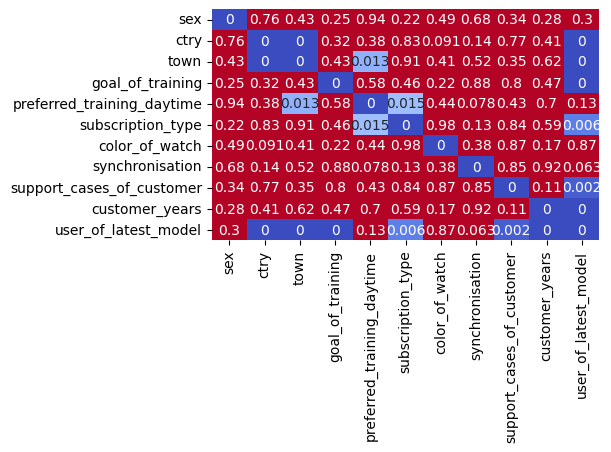

In [1752]:
#display chi2 p-values as a color coded heatmap with a threshold of 0.05, round p-values to 2 digits
plt.figure(figsize=(5,3))
sns.heatmap(round(chi2_values.astype(float),3), annot=True, cmap='coolwarm', cbar=False, vmin=0, vmax=0.05)

 Chi2 that the variables ctry, town, goal_of_training, subscription_type, support_cases_of_customer and customer_years have an significant effect on the target variable:

In [1753]:
non_continuous_columns_of_interest = ['ctry','town','goal_of_training','subscription_type','support_cases_of_customer','customer_years']

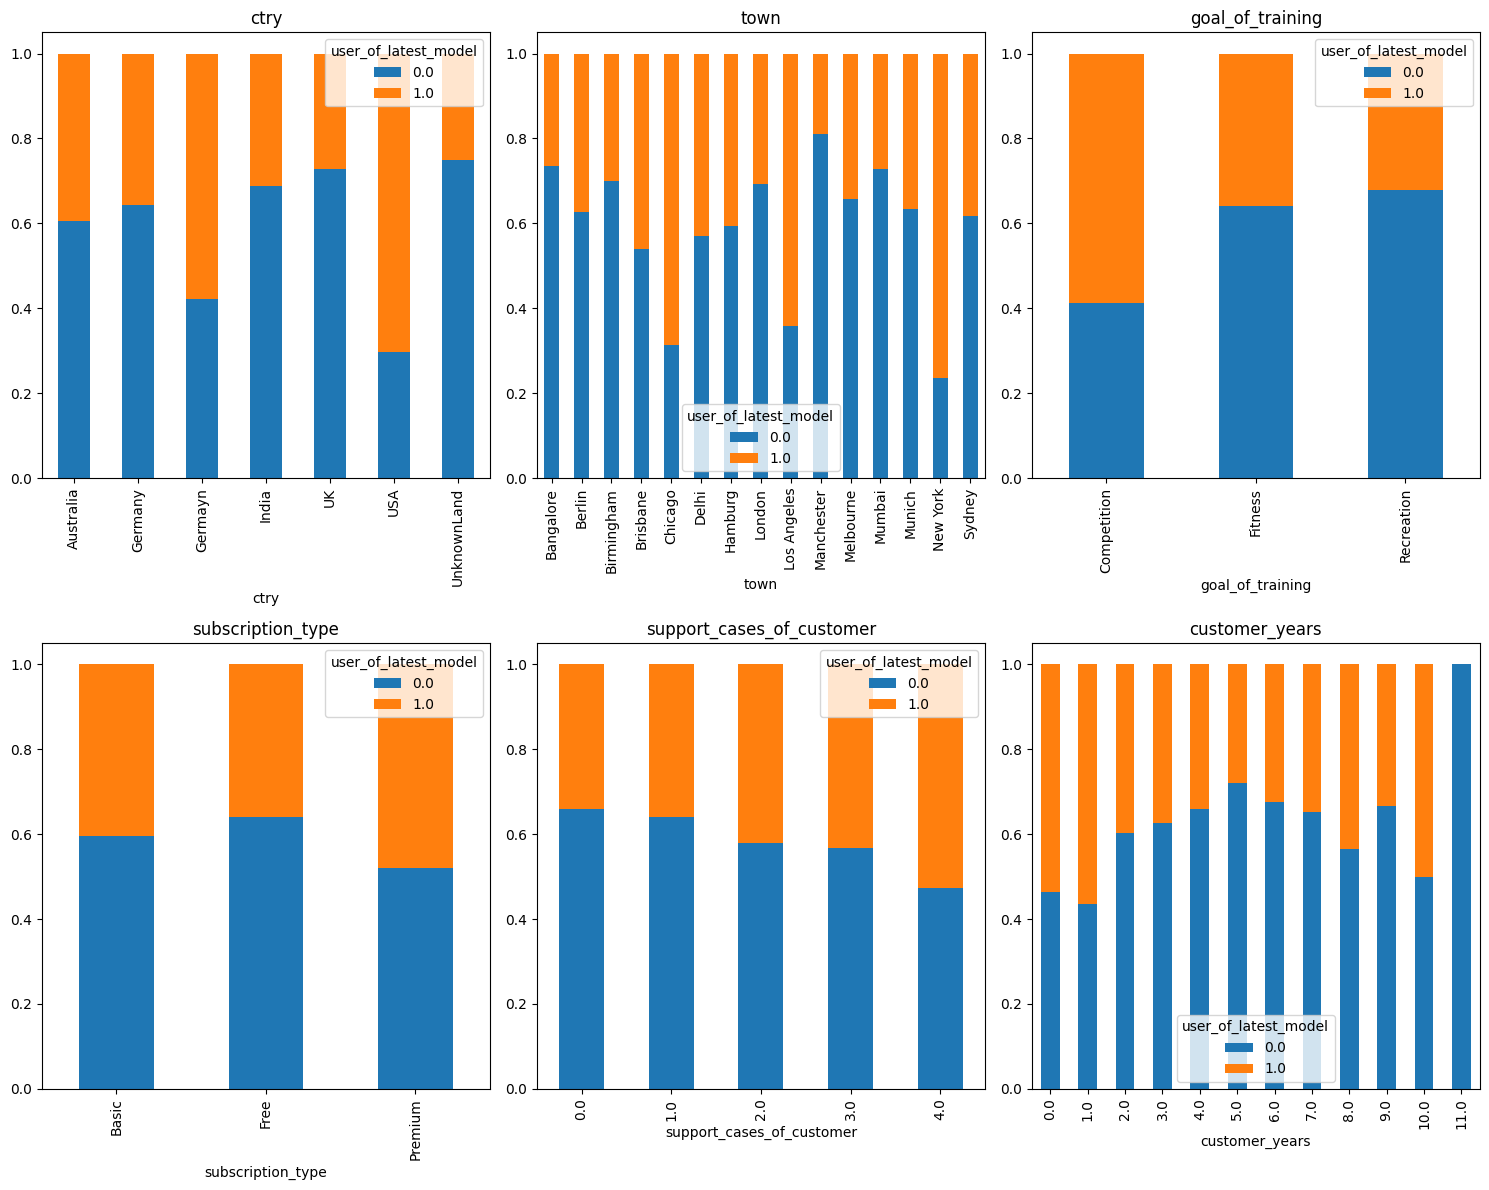

In [1754]:
#create a stacked bar plot of the relative survival/non survial for columns of interest
fig, axes = plt.subplots(2, 3, figsize=(15, 12))  # 3x3 Grid, Größe anpassen
axes = axes.flatten()  # 2D-Array in 1D-Liste umwandeln

for i, col in enumerate(non_continuous_columns_of_interest):
    data = pd.crosstab(df_step9[col], df_step9['user_of_latest_model'])
    data = data.div(data.sum(axis=1), axis=0)  # Normalisierung der Werte
    data.plot(kind='bar', stacked=True, ax=axes[i])  # Plot in entsprechendes Subplot einfügen
    axes[i].set_title(col)  # Titel setzen

# Layout optimieren
plt.tight_layout()
plt.show()

The plots show that, the distribution of the target variable is not randomly across the selected non continuous columns. The other columns will be eliminated for the logistic regression model

In [1755]:
df_step9 = df_step9[coninuous_features_of_interest + non_continuous_columns_of_interest + ['user_of_latest_model']]

In [1756]:
check_processing_step(df_step9, 'Feature selection')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590
4,Quantile Transformation,0.780612,0.718954
5,Power Transformation,0.795918,0.740260
6,Feature scaling - Normalization,0.780612,0.722581
7,Feature scaling - Standardization,0.785714,0.734177
8,Ordinal encoding,0.785714,0.727273
9,Feature selection,0.780612,0.718954


## Step 10 - Feature extraction

In [1757]:
df_step10 = df_step0.copy()

In [1758]:
numeric_features = numeric.copy() 
numeric_features.remove('user_of_latest_model')

In [1759]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# Features und Ziel trennen
X = df_step10.drop('user_of_latest_model', axis=1)
y = df_step10['user_of_latest_model']


# Pipeline für die Vorverarbeitung
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ]
)

# PCA anwenden
pca = PCA(n_components=2)

# Gesamte Pipeline: Vorverarbeitung + PCA
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca)
])

# Pipeline auf die Daten anwenden
X_pca = pipeline.fit_transform(X)

# Ergebnisse anzeigen

print("Erklärte Varianz:", pca.explained_variance_ratio_)

X_pca




Erklärte Varianz: [0.21572926 0.12972314]


array([[-3.21058441,  1.08959752],
       [ 0.35380279,  2.28522449],
       [ 4.00981283,  0.12045194],
       ...,
       [ 0.78148427, -1.04297435],
       [ 0.61959895, -1.34758804],
       [ 1.44048233, -0.77041558]])

In [1760]:
# PCA-Ergebnis wieder in DataFrame umwandeln
df_step10 = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
df_step10['user_of_latest_model'] = y.values  # Optional: Label hinzufügen

df_step10

,PC1,PC2,user_of_latest_model
0,-3.210584,1.089598,1.0
1,0.353803,2.285224,0.0
2,4.009813,0.120452,1.0
3,-0.372358,-1.313091,1.0
4,-2.953373,1.911011,0.0
...,...,...,...
973,-0.972115,-2.053906,0.0
974,-2.033716,0.865835,0.0
975,0.781484,-1.042974,1.0
976,0.619599,-1.347588,1.0


In [1761]:
check_processing_step(df_step10, 'Feature extraction')
df_check

,Dataset,Accuracy,F1-Score
0,Minimal Preprocessing (baseline),0.780612,0.722581
1,Data Quality Corrections,0.739796,0.662252
2,Missing values imputation,0.785714,0.727273
3,Outlier Imputation,0.795918,0.743590
4,Quantile Transformation,0.780612,0.718954
5,Power Transformation,0.795918,0.740260
6,Feature scaling - Normalization,0.780612,0.722581
7,Feature scaling - Standardization,0.785714,0.734177
8,Ordinal encoding,0.785714,0.727273
9,Feature selection,0.780612,0.718954


In [1762]:
# Differenz berechnen und als neue Spalte hinzufügen
df_check['Accuracy_baseline_difference'] = df_check['Accuracy'] - df_check.loc[0, 'Accuracy']
df_check['F1-score_baseline_difference'] = df_check['F1-Score'] - df_check.loc[0, 'F1-Score']
df_check

,Dataset,Accuracy,F1-Score,Accuracy_baseline_difference,F1-score_baseline_difference
0,Minimal Preprocessing (baseline),0.780612,0.722581,0.000000,0.000000
1,Data Quality Corrections,0.739796,0.662252,-0.040816,-0.060329
2,Missing values imputation,0.785714,0.727273,0.005102,0.004692
3,Outlier Imputation,0.795918,0.743590,0.015306,0.021009
4,Quantile Transformation,0.780612,0.718954,0.000000,-0.003626
5,Power Transformation,0.795918,0.740260,0.015306,0.017679
6,Feature scaling - Normalization,0.780612,0.722581,0.000000,0.000000
7,Feature scaling - Standardization,0.785714,0.734177,0.005102,0.011597
8,Ordinal encoding,0.785714,0.727273,0.005102,0.004692
9,Feature selection,0.780612,0.718954,0.000000,-0.003626


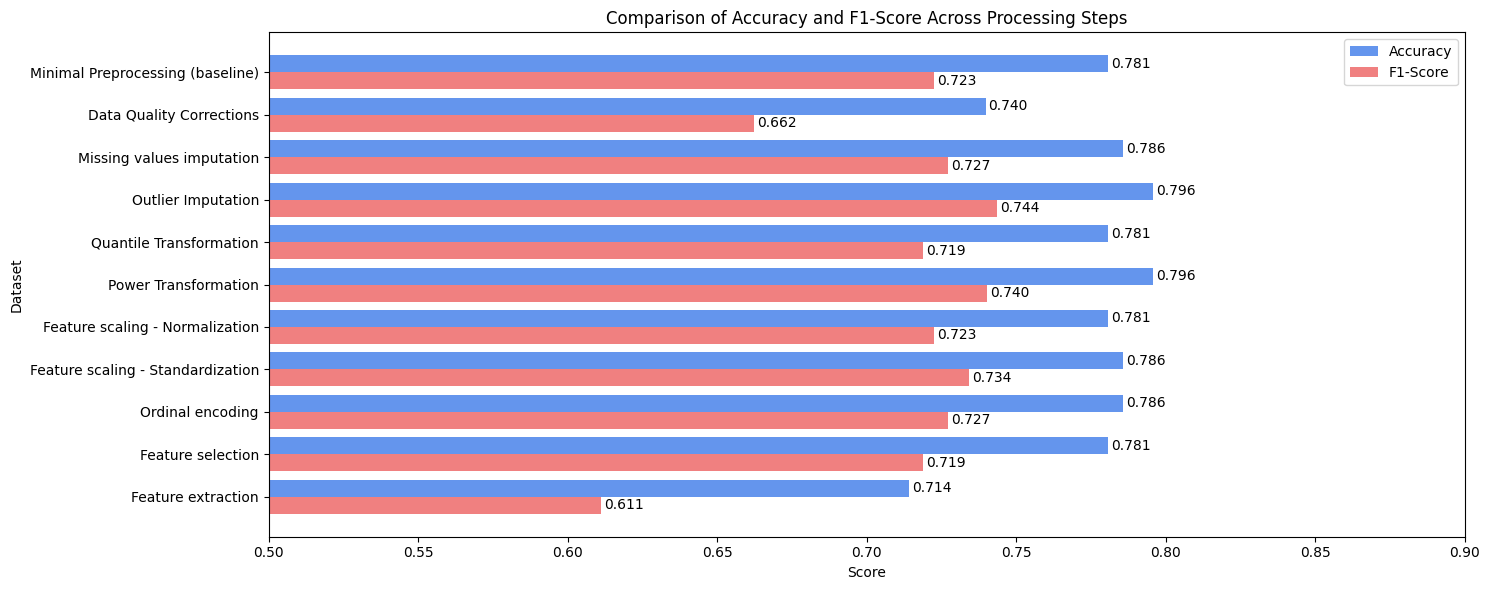

In [1763]:
plt.figure(figsize=(15, 6))

bar_height = 0.4
y = range(len(df_check))

# Bars for Accuracy
plt.barh(y, df_check['Accuracy'], height=bar_height, color='cornflowerblue', label='Accuracy')
for i, value in enumerate(df_check['Accuracy']):
    plt.text(value + 0.001, i, f'{value:.3f}', va='center', fontsize=10)  # Adds label to Accuracy bars

# Bars for F1-Score (shifted downward)
plt.barh([pos + bar_height for pos in y], df_check['F1-Score'], height=bar_height, color='lightcoral', label='F1-Score')
for i, value in enumerate(df_check['F1-Score']):
    plt.text(value + 0.001, i + bar_height, f'{value:.3f}', va='center', fontsize=10)  # Adds label to F1-Score bars

# Customize axis labels and title
plt.ylabel('Dataset')
plt.xlabel('Score')
plt.yticks([pos + bar_height / 2 for pos in y], df_check['Dataset'])
plt.title('Comparison of Accuracy and F1-Score Across Processing Steps')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0.5, 0.9) 
plt.tight_layout()
plt.show()




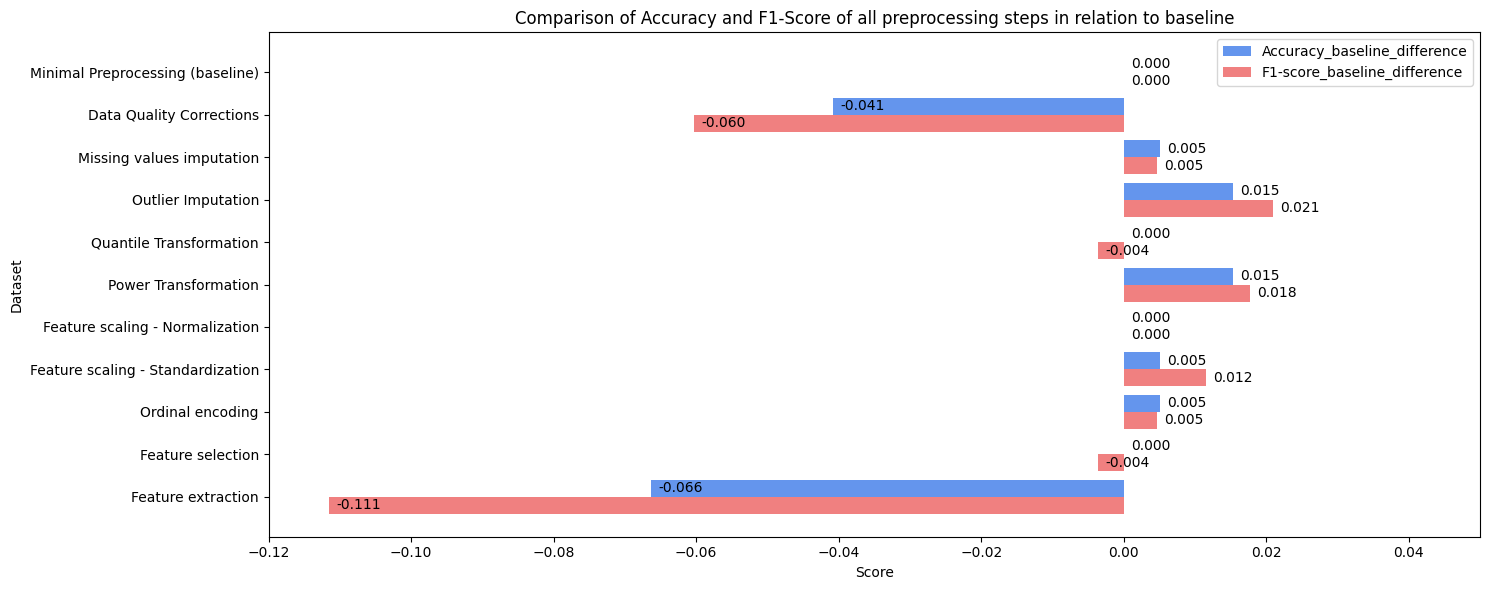

In [1780]:
plt.figure(figsize=(15, 6))

bar_height = 0.4
y = range(len(df_check))

# Bars for Accuracy
plt.barh(y, df_check['Accuracy_baseline_difference'], height=bar_height, color='cornflowerblue', label='Accuracy_baseline_difference')
for i, value in enumerate(df_check['Accuracy_baseline_difference']):
    plt.text(value + 0.001, i, f'{value:.3f}', va='center', fontsize=10)  # Adds label to Accuracy bars

# Bars for F1-Score (shifted downward)
plt.barh([pos + bar_height for pos in y], df_check['F1-score_baseline_difference'], height=bar_height, color='lightcoral', label='F1-score_baseline_difference')
for i, value in enumerate(df_check['F1-score_baseline_difference']):
    plt.text(value + 0.001, i + bar_height, f'{value:.3f}', va='center', fontsize=10)  # Adds label to F1-Score bars

# Customize axis labels and title
plt.ylabel('Dataset')
plt.xlabel('Score')
plt.yticks([pos + bar_height / 2 for pos in y], df_check['Dataset'])
plt.title('Comparison of Accuracy and F1-Score of all preprocessing steps in relation to baseline')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(-0.12, 0.05) 
plt.tight_layout()
plt.show()




In [1764]:
df_step0.to_csv("../../data/processed/triathlon_watch_training_preprocessed_samu_prep_0.csv", index=False)

## Missing value imputation of test data

In [1765]:
df_test = pd.read_csv("../../data/raw/triathlon_watch_test_data_final.csv")
df_test.shape

(500, 21)

In [1766]:
df_test.columns = df_test.columns.str.lower()
# Replace spaces with underscores
df_test.columns = df_test.columns.str.replace(r" ", r"_", regex=True)

In [1767]:
#Elimiate column ID from the data set
df_test = df_test.drop(columns=['id'])

In [1768]:
#Transform the date column into numeric column
df_test["most_current_software_update"] = pd.to_datetime(df_test["most_current_software_update"], format="%Y-%m-%d")
df_test["most_current_software_update"] = df_test["most_current_software_update"].max() - df_test["most_current_software_update"]
df_test["most_current_software_update"] = df_test["most_current_software_update"].dt.days

In [1769]:
#Split column names in numerical and categorical features
numeric=df_test.select_dtypes(include=['float64']).columns.tolist() #list of numeric columns
categorical = df_test.select_dtypes(include=['object']).columns.to_list() #append all categorical columns to a list

<Axes: >

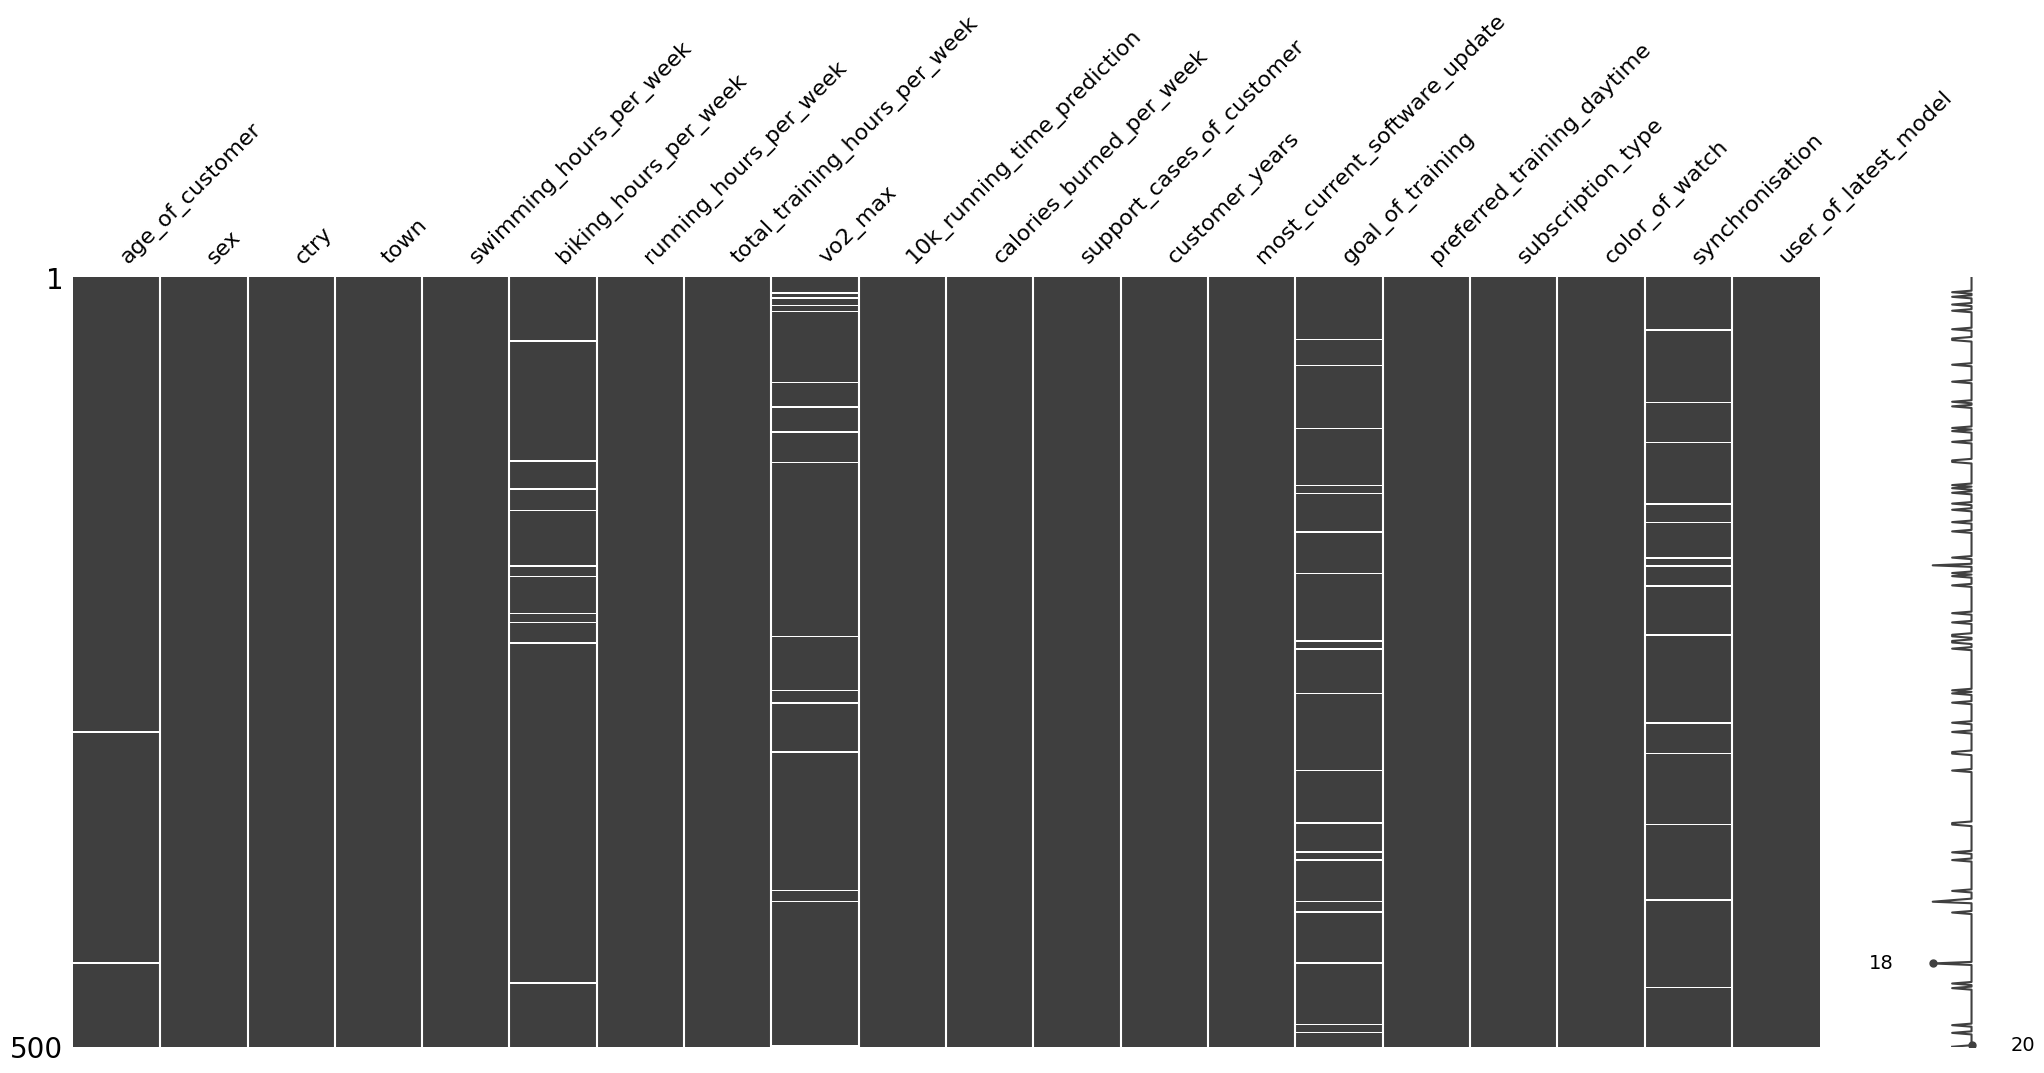

In [1770]:
msno.matrix(df_test)

### Mean value imputation of numeric missing values

In [1771]:
#replace missing values in numeric columns with mean of the training data
for col in numeric:
    imputer = SimpleImputer(strategy='mean')
    # Fit and transform with the training data
    imputer.fit_transform(df[[col]])
    # Apply the imputation to the test data
    df_test[col] = imputer.transform(df_test[[col]])

### Modus imputation of categorical missing values

In [1772]:
#replace missing values in categorical columns with modus
for col in categorical:
   # Calculate the mode of the column
    mode_value = df[col].mode()[0]  # mode() returns a Series, [0] extracts the value
    # Replace missing values with the mode
    df_test[col] = df_test[col].fillna(mode_value)

<Axes: >

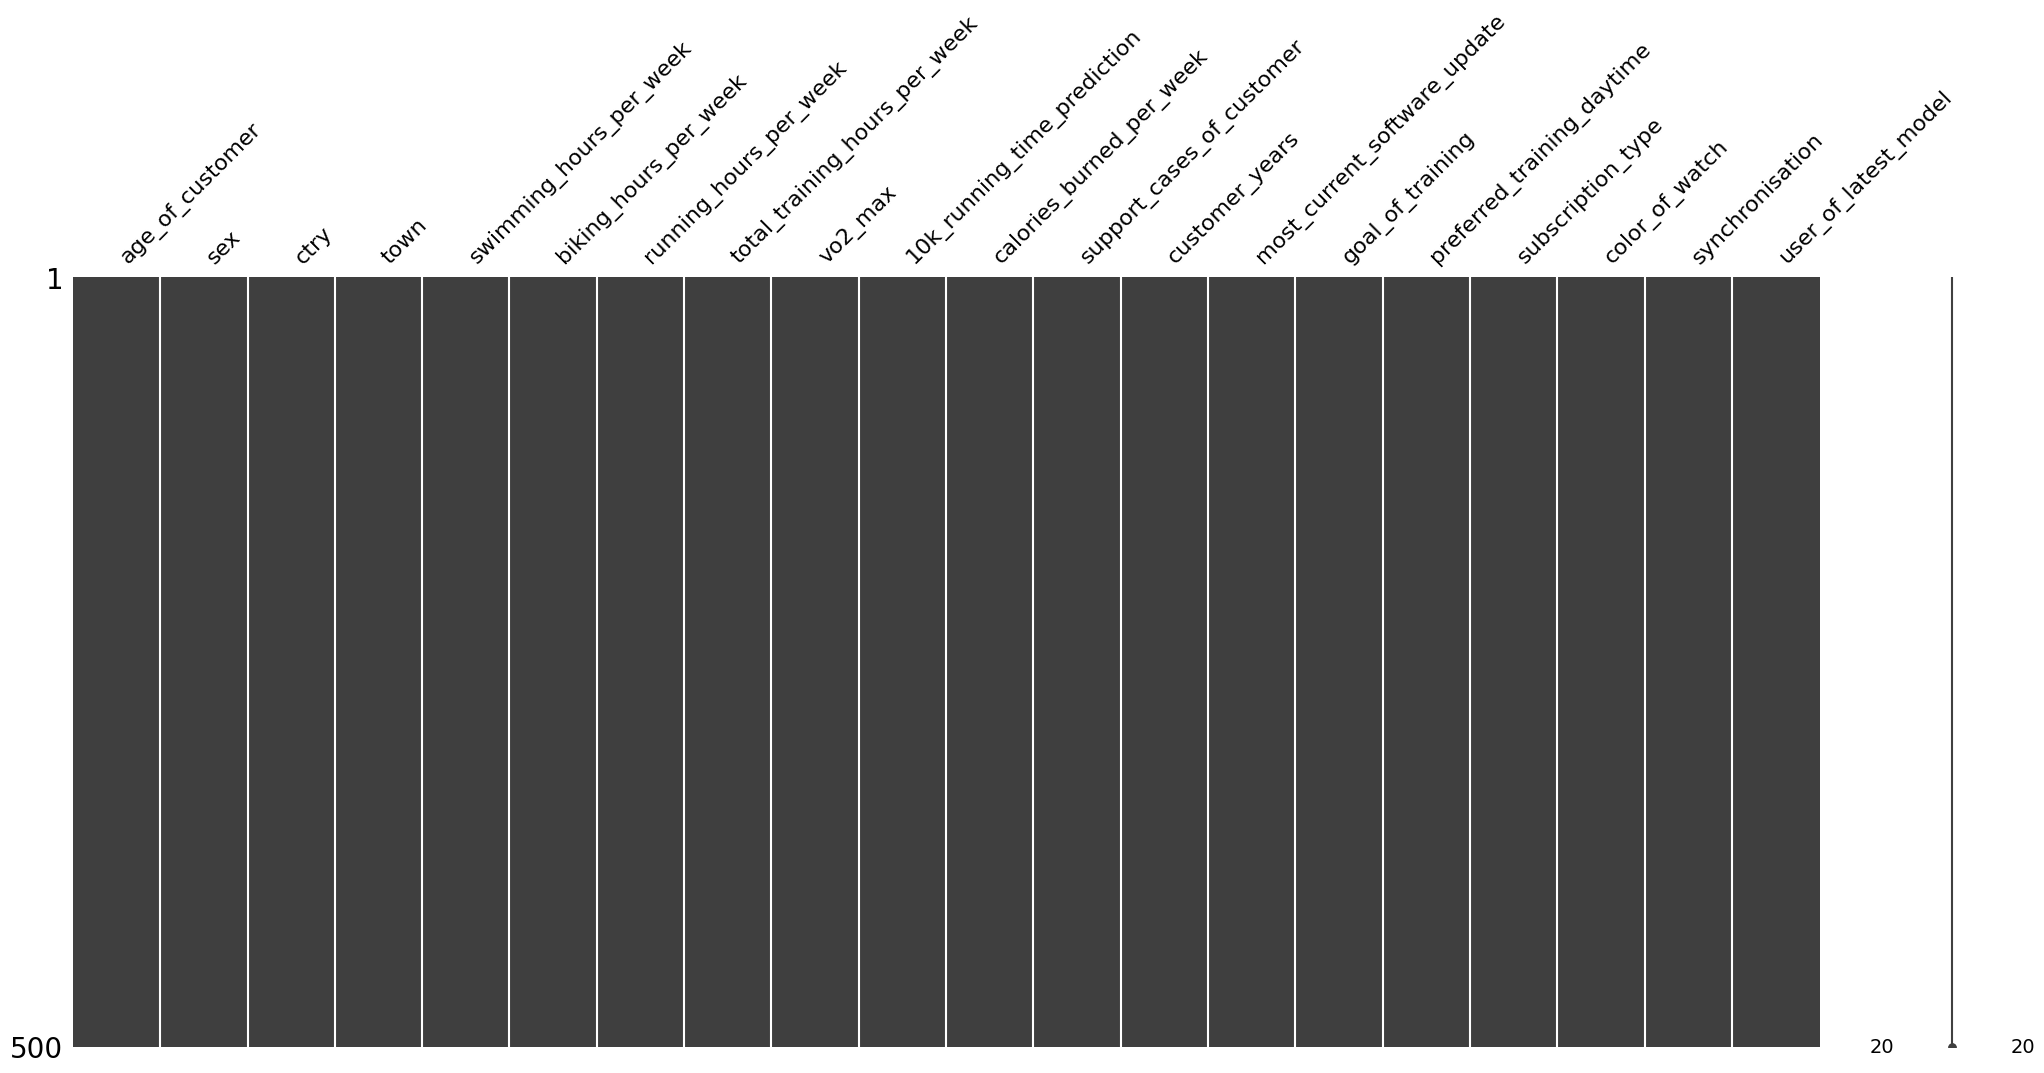

In [1773]:
msno.matrix(df_test)

In [1774]:
df_test.to_csv("../../data/processed/triathlon_watch_test_preprocessed_samu.csv", index=False)